# Trabalho Sobre Transferencia de Estilo com redes CNN

As redes convolucionais para transferência de estilo, também conhecidas como redes convolucionais neurais estilísticas (CNNs), são um tipo de arquitetura de rede neural utilizada para combinar o conteúdo de uma imagem de entrada com o estilo de uma imagem de referência. Essa técnica permite que uma imagem adquira características visuais semelhantes às de uma pintura ou de uma imagem estilizada.

In [ ]:
import tensorflow as tf
import numpy as np
from keras.utils import get_file
import matplotlib.pyplot as plt

In [ ]:
base_image_path = '/content/o-que-e-paisagem.jpg'
style_image_path = '/content/Pensamento-Criativo.jpg'

# Entendendo como funciona uma transferência de estilo neural
## 1 - Transmita o estilo o máximo possível.
## 2 - Certifique-se de que a imagem resultante pareça o mais próxima possível da imagem original.

Metodo: 
Uma rede neural convolucional já treinada (como VGG19).
Três imagens serão passadas para esta rede: a imagem base, a imagem de estilo e a imagem de combinação. 

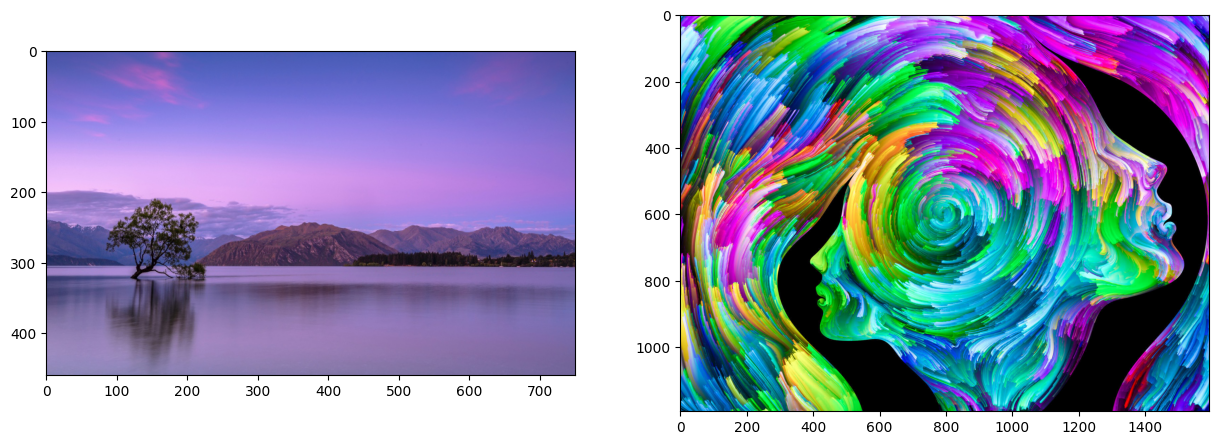

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Armazena Imagem no Array e plota as duas imagens
a = plt.imread(base_image_path)
b = plt.imread(style_image_path)
f, axarr = plt.subplots(1,2, figsize=(15,15))
axarr[0].imshow(a)
axarr[1].imshow(b)
plt.show()

Se quisermos transferir o estilo de uma imagem, teremos que fazer com que os valores das feições das camadas profundas de nossa rede se pareçam com os da rede da imagem de estilo.

Mas como podemos calcular a função perda desse processo para ajustá-lo? Para isso, utilizamos a chamada Gram Matrix.

A matriz de Gram captura informações importantes sobre as características da imagem. Ela reflete as relações de intensidade e estrutura entre os diferentes canais de cores, ajudando a identificar padrões e texturas na imagem.

Corelação entre as features e a imagem

A gram Matrix é uma matriz que nos ajuda a medir a semelhança entre diferentes filtros em uma camada de uma rede neural convolucional.


Para calcular a Gram Matrix, primeiro precisamos achatar a camada em questão, ou seja pegamos cada matriz ativação de um filtro e colocamos em um unico vetor(unidimensional).





In [ ]:
def gram_matrix(x):
    # reorganizar as dimensões 
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

### def coste_estilo calcula a função de custo para a transferência de estilo entre duas imagens: uma imagem de estilo (style) e uma imagem de combinação (combination). A função de custo é calculada com base nas matrizes de Gram das imagens.
### Essa função de custo é comumente utilizada em algoritmos para quantificar a diferença entre as características de estilo da imagem de estilo e da imagem de combinação. O objetivo é minimizar esse custo para obter uma imagem de combinação que capture o estilo da imagem de estilo.

In [ ]:
def coste_estilo(style, combination):
    # A Gram Matrix captura as informações de correlação entre os filtros na camada de estilo.
    S = gram_matrix(style)
    #  A Gram Matrix captura as informações de correlação entre os filtros na camada combinada.
    C = gram_matrix(combination)
    channels = 3
    # Retorna a perda de estilo normalizada. 
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

### Como fazer com que a imagem resultante se pareça com a imagem original?

### a função coste_contenido calcula o custo de diferença quadrada entre a imagem base e a imagem de combinação, medindo a discrepância no conteúdo visual das imagens.

## função de perda de conteúdo é muito mais simples que a função de estilo. Por que? Porque, segundo estudos , imagens semelhantes tendem a ter camadas de profundidade semelhantes.

In [ ]:
def coste_contenido(base, combination):
  #calcula a funçao custo(discrepancia)
  return tf.reduce_sum(tf.square(combination - base))

### Arquitetura da rede VGG19

In [ ]:
from tensorflow.keras.applications import vgg19
from keras.utils import plot_model
model = vgg19.VGG19(weights="imagenet", include_top=False)

model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
from keras import Model

outputs_dict= dict([(layer.name, layer.output) for layer in model.layers])
# cria um modelo relacionando as saidas da rede convolucional para extrair caracteristicas 
feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

Ao criar esse novo modelo feature_extractor, estamos efetivamente criando uma nova rede neural que compartilha os pesos com o modelo VGG16 original, mas com a vantagem de podermos acessar as saídas de cada camada individualmente

Agora vamos definir quais camadas usaremos para calcular a função perda do estilo e qual camada usaremos para calcular a função perda do conteúdo.

Para calcular a função de perda de estilo usaremos a primeira convolução de cada bloco, enquanto para o conteúdo usaremos a segunda convolução do último bloco.

In [ ]:
capas_estilo = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

capas_contenido = "block5_conv2"

content_weight = 2.5e-8
style_weight = 1e-6

def loss_function(combination_image, base_image, style_reference_image):

    # 1. Combina todas as imagens em um mesmo tensor.
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )

    # 2. Extrair caracteristica na combinação das 3 imagens.
    features = feature_extractor(input_tensor)

    #3. Inicializar a perda
    loss = tf.zeros(shape=())

    # 4. Extraia as camadas de conteúdo para a imagem base e mescle e calcule a função de perda de conteúdo.
    layer_features = features[capas_contenido]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + content_weight * coste_contenido(
        base_image_features, combination_features
    )
    # 5. Extraia as camadas de estilo para a imagem de estilo e a imagem de combinação e calcule a função de perda de estilo.
    for layer_name in capas_estilo:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = coste_estilo(style_reference_features, combination_features)
        loss += (style_weight / len(capas_estilo)) * sl

    return loss

Agora que temos a função de custo, temos que calcular os deltas, que são o que o gradiente descendente (ou qualquer outro otimizador) usa para encontrar nossos valores ideais.

In [ ]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = loss_function(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

O pré-processamento das imagens consiste em dar às imagens o formato que nossa rede requer. No caso do Keras, por se tratar do modelo VGG19, o próprio modelo possui uma função de pré-processamento de imagem: preprocess_input.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(image_path):
    # Função utilitária para abrir, redimensionar e formatar imagens em tensores apropriados.
    img = image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [ ]:
def deprocess_image(x):

    # Conveter o tensor em array
    x = x.reshape((img_nrows, img_ncols, 3))

    # Hacemos que no tengan promedio 0
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # Convertimos de BGR a RGB.
    x = x[:, :, ::-1]

    # Nos aseguramos que están entre 0 y 255
    x = np.clip(x, 0, 255).astype("uint8")

    return x

Função para salvar a imagem

In [ ]:
from datetime import datetime

def result_saver(iteration):
  # Create name
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  #model_name = str(i) + '_' + str(now)+"_model_" + '.h5'
  image_name = str(i) + '_' + str(now)+"_image" + '.png'

  # Save image
  img = deprocess_image(combination_image.numpy())
  keras.preprocessing.image.save_img(image_name, img)

# Agora que temos tudo preparado, vamos codificar o treinamento da nossa rede de transferência Neural Style 
### 1 - Pré-processar imagens e criar a imagem combinada,
### 2- Iterativamente, calcule a perda e aplique os gradientes à imagem combinada.
### 3 - A cada poucas iterações, mostre o erro e salve a imagem gerada e o modelo. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image

width, height = Image.open(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

learning_rate = ExponentialDecay(
    initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
)
optimizer = SGD(learning_rate)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        result_saver(i)


Iteration 10: loss=58186.17
Iteration 20: loss=27953.07
Iteration 30: loss=16359.96
Iteration 40: loss=12396.46
Iteration 50: loss=10592.29
Iteration 60: loss=9256.54
Iteration 70: loss=8592.94
Iteration 80: loss=7900.40
Iteration 90: loss=7338.40
Iteration 100: loss=6985.51
Iteration 110: loss=6624.92
Iteration 120: loss=6299.80
Iteration 130: loss=6053.59
Iteration 140: loss=5834.17
Iteration 150: loss=5618.30
Iteration 160: loss=5432.23
Iteration 170: loss=5266.17
Iteration 180: loss=5111.57
Iteration 190: loss=4966.12
Iteration 200: loss=4833.79
Iteration 210: loss=4712.13
Iteration 220: loss=4597.20
Iteration 230: loss=4489.91
Iteration 240: loss=4391.88
Iteration 250: loss=4299.01
Iteration 260: loss=4209.24
Iteration 270: loss=4124.30
Iteration 280: loss=4046.23
Iteration 290: loss=3971.56
Iteration 300: loss=3899.84
Iteration 310: loss=3832.48
Iteration 320: loss=3768.77
Iteration 330: loss=3707.37
Iteration 340: loss=3648.33
Iteration 350: loss=3592.31
Iteration 360: loss=3538

# Imagem Base

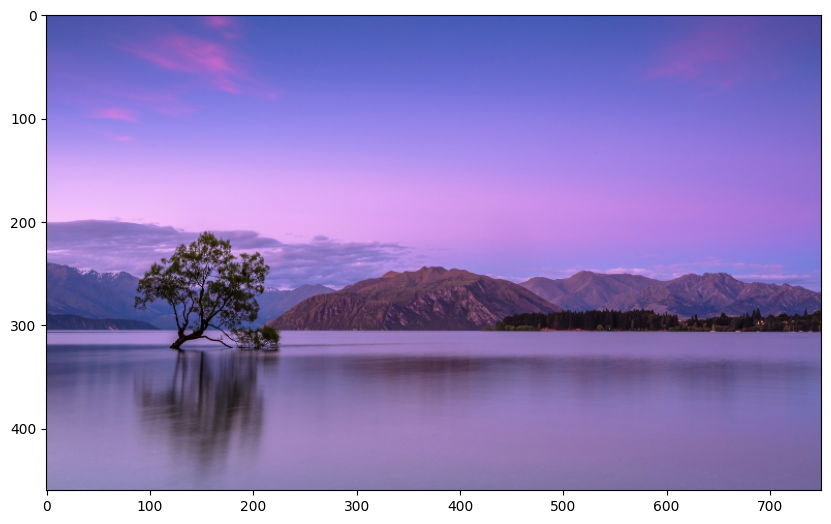

In [ ]:
# Load the image
a = plt.imread('/content/WhatsApp Image 2023-05-30 at 07.55.28.jpeg')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Display the image
ax.imshow(a)

# Show the plot
plt.show()

# Imagem Estilo

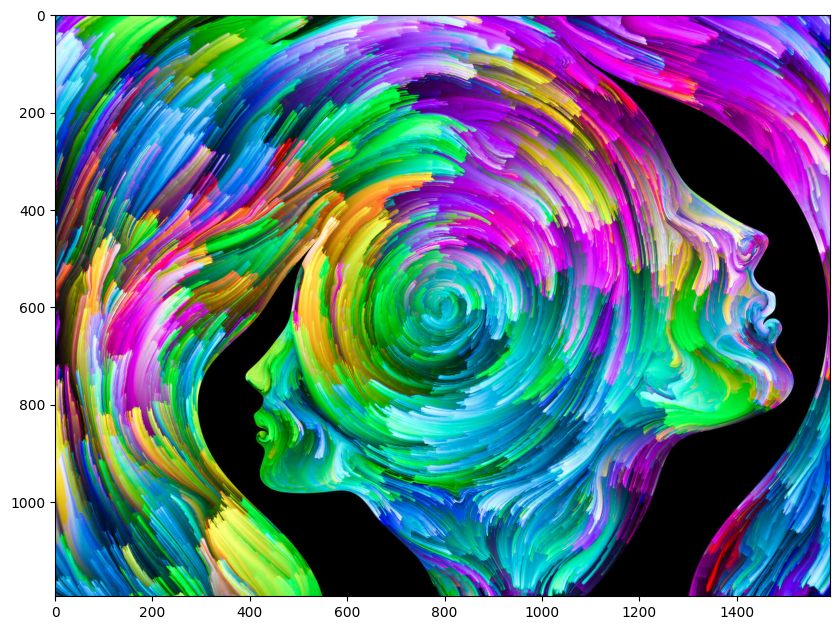

In [ ]:
# Load the image
a = plt.imread('/content/WhatsApp Image 2023-05-30 at 07.55.25.jpeg')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Display the image
ax.imshow(a)

# Show the plot
plt.show()

# Imagem Resultante

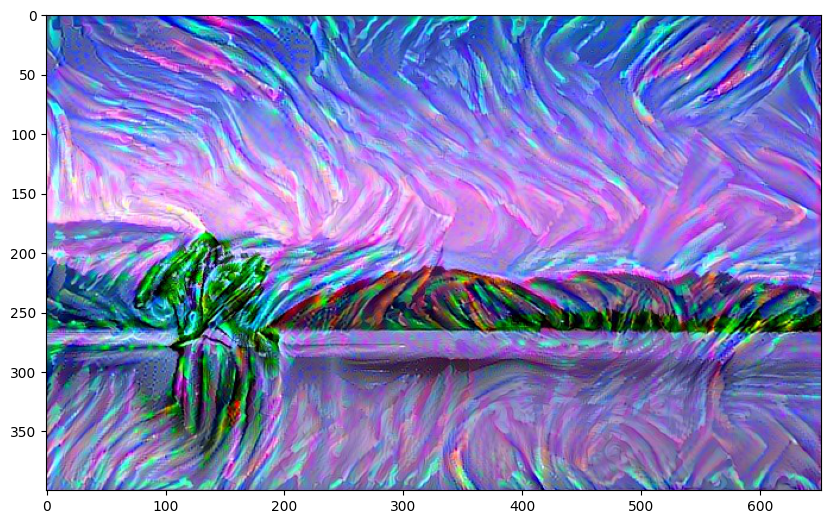

In [ ]:
# Load the image
a = plt.imread('/content/WhatsApp Image 2023-05-30 at 07.55.26.jpeg')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Display the image
ax.imshow(a)

# Show the plot
plt.show()